Instructions:<br>
Design a regression system to predict housing prices. The data are available at: https://www.kaggle.com/vikrishnan/boston-house-prices. The regression algorithms should contain ridge regression, lasso regression, decision tree for regression, etc.

Loading data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

data = pd.read_csv('data_boston.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Preprocessing dataset<br>

Use openrefine to examine the data, we can spot on that there are too many data point whose MEDV equals 50, those data should be excludeed.
<br>
<img src='./1.jpg',width= 1000, height = 200><br>

In [2]:
data = data[data.MEDV  != 50]    # exclude the data where MEDV = 50
X = data.iloc[ : , :-1]
y = data.iloc[ : , -1]

Spliting dataset into training set and tests set

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.1, random_state=0)

Feature scaling

In [4]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

Define the function for the purpose of evaluating the model

In [5]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen.
    """
    from sklearn.metrics import r2_score
    score = r2_score(y_true, y_predict)
    return score

# Ridge regression

Import the `Ridge` model

In [6]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

Calculate this model's coefficient of determination.

In [7]:
performance_metric(y_test, y_pred_ridge)

0.7449533734392804

Model has a coefficient of determination, R^2, of 0.74495.

# Lasso regression

Import the `Lasso` model

In [8]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

Calculate this model's coefficient of determination.

In [9]:
performance_metric(y_test, y_pred_lasso)

0.7449242162481912

Model has a coefficient of determination, R^2, of 0.74492.

# Advenced exporation about linear regression

The R^2 is too small so that two models above can be regard as failure, I decided to evaluate the features deeper

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
data['predicted'] = model.predict(X)

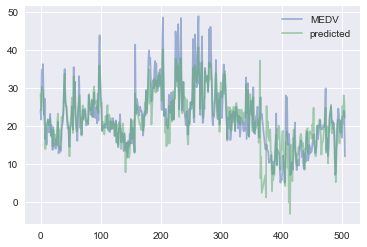

In [11]:
data[['MEDV', 'predicted']].plot(alpha=0.5);

Take a look at the coefficients of the linear model to estimate how much each feature contributes to the MEDV:

In [12]:
params = pd.Series(model.coef_, index=X.columns)
params

CRIM      -0.092301
ZN         0.036045
INDUS     -0.065488
CHAS       0.558426
NOX        0.531009
RM         5.744305
AGE       -0.032001
DIS       -0.773066
RAD        0.130230
TAX       -0.011328
PTRATIO   -0.366734
B          0.012635
LSTAT     -0.242229
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty.<br>
We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [13]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [14]:
pd.DataFrame({'effect': params, 'error': err, 'error/params': np.fabs(err / params)})

,effect,error,error/params
CRIM,-0.092301,0.041814,0.453017
ZN,0.036045,0.012427,0.344769
INDUS,-0.065488,0.041207,0.629240
CHAS,0.558426,0.784258,1.404408
NOX,0.531009,3.082824,5.805598
RM,5.744305,0.498991,0.086867
AGE,-0.032001,0.012704,0.396991
DIS,-0.773066,0.142920,0.184875
RAD,0.130230,0.049579,0.380699
TAX,-0.011328,0.002405,0.212324


As we can see, `RM ` has a significent positive effect, `PTRATIO` and `LSTAT` have positive but relatively trivial effect. `DIS` has small and negative effect. The rest of features are ambiguous

# Decision tree regression

Produce learning curves for varying training set sizes and maximum depths<br>
And we have learned that the features `RM`, `LSTAT`, `PTRATIO` and `DIS` are essential, from now on I use only these features.

C:\Users\28347\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


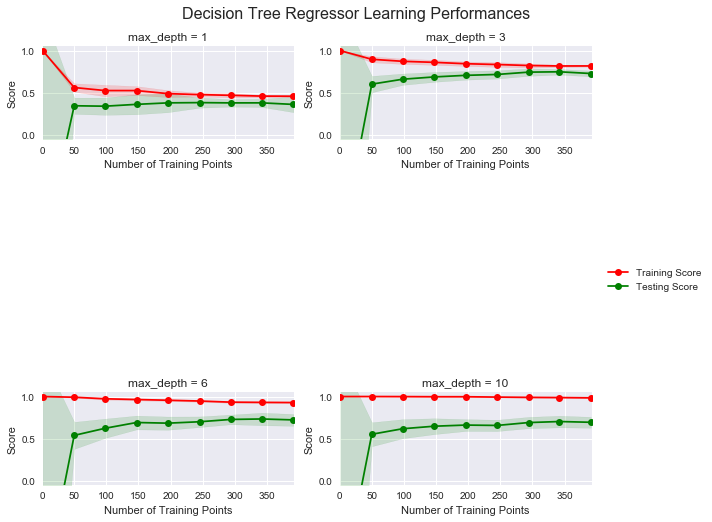

In [15]:
X = X[['RM', 'DIS', 'PTRATIO', 'LSTAT']]
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.1, random_state=0)

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.cross_validation import ShuffleSplit

#cv = ShuffleSplit(n_splits=10, test_size = 0.2, random_state = 0)
cv = ShuffleSplit(X.shape[0], n_iter=10, test_size = 0.2, random_state = 0)
# Generate the training set sizes increasing by 50
train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)
# Create the figure window
fig = plt.figure(figsize=(10,7))
# Create three different models based on max_depth
for k, depth in enumerate([1,3,6,10]):
    # Create a Decision tree regressor at max_depth = depth
    regressor = DecisionTreeRegressor(max_depth = depth)
    # Calculate the training and testing scores
    sizes, train_scores, test_scores = learning_curve(regressor, X, y, cv = cv, train_sizes = train_sizes, scoring = 'r2')  
    # Find the mean and standard deviation for smoothing
    train_std = np.std(train_scores, axis = 1)
    train_mean = np.mean(train_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    # Subplot the learning curve 
    ax = fig.add_subplot(2, 2, k+1)
    ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
    ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
    ax.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
    ax.fill_between(sizes, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')
    # Labels
    ax.set_title('max_depth = %s'%(depth))
    ax.set_xlabel('Number of Training Points')
    ax.set_ylabel('Score')
    ax.set_xlim([0, X.shape[0]*0.8])
    ax.set_ylim([-0.05, 1.05])

ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
fig.tight_layout()

The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the learning curves, the shaded regions of both the complexity curves denote the uncertainty in those curves.

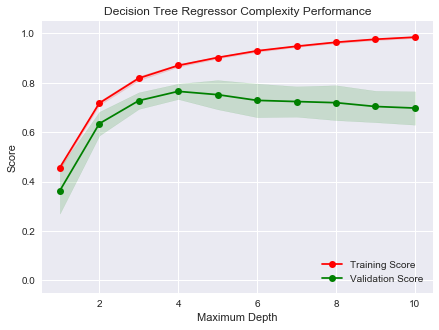

In [16]:
from sklearn.model_selection import validation_curve, KFold

# Create 10 cross-validation sets for training and testing
cv = ShuffleSplit(X.shape[0], n_iter=10, test_size = 0.2, random_state = 0)
# Vary the max_depth parameter from 1 to 10
max_depth = np.arange(1,11)

# Calculate the training and testing scores
train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X, y, \
                                                    param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')
# Find the mean and standard deviation for smoothing
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Plot the validation curve
plt.figure(figsize=(7, 5))
plt.title('Decision Tree Regressor Complexity Performance')
plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
plt.fill_between(max_depth, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
plt.fill_between(max_depth, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')
    
# Visual aesthetics
plt.legend(loc = 'lower right')
plt.xlabel('Maximum Depth')
plt.ylabel('Score')
plt.ylim([-0.05,1.05]);

Looks `depth=4` is the best chioce

Use grid search to find the best option

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.10, random_state = 0)
    regressor = DecisionTreeRegressor(random_state = 1)
    tree_range = range(1, 11)
    params = dict(max_depth=[1,2,3,4,5,6,7,8,9,10])
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)
    grid.fit(X, y)
    return grid.best_estimator_

reg = fit_model(X_train, y_train)
reg.get_params()

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 1,
 'splitter': 'best'}

`maxdepth=4`

In [18]:
pred = reg.predict(X_test)
performance_metric(y_test, pred)

0.7212326834989833